In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 12

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Potato Database/',
    shuffle= True,
    image_size= (Image_size, Image_size),
    batch_size= Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# It will show only the batches..

len(dataset)

68

In [6]:
# the answer is around the total imagese of the dataset

68 * 32

2176

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 2 0 1 1 0 0 1 0 2 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0]


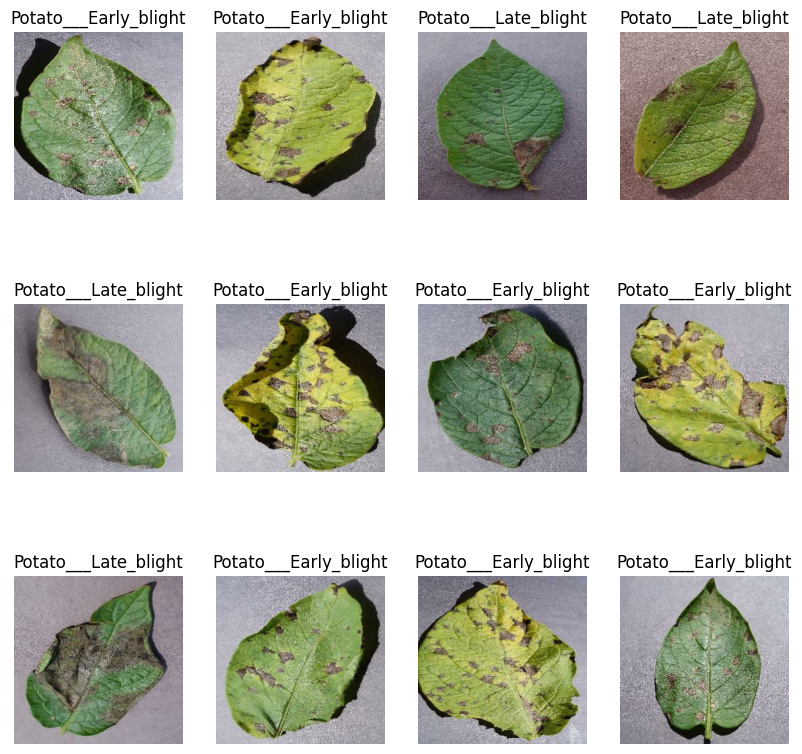

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')


train set = 80 %

validation set = 10 %

test set = 10 %

In [9]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

i have to see the below lecture from codebasics.... optimized cpu an gpu

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [21]:
input_images = (Batch_size, Image_size, Image_size, Channels)
# (32, 256, 256, 3)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_images),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(rate=0.4),
    
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(rate=0.4),    
  
    layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(rate=0.4),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_images)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [23]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    validation_data= val_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1
)


Epoch 1/12
54/54 [==============================] - 41s 375ms/step - loss: 0.8650 - accuracy: 0.5382 - val_loss: 0.7549 - val_accuracy: 0.6667
Epoch 2/12
54/54 [==============================] - 16s 295ms/step - loss: 0.6942 - accuracy: 0.6777 - val_loss: 0.6264 - val_accuracy: 0.6979
Epoch 3/12
54/54 [==============================] - 15s 272ms/step - loss: 0.4957 - accuracy: 0.7894 - val_loss: 0.3939 - val_accuracy: 0.8542
Epoch 4/12
54/54 [==============================] - 15s 270ms/step - loss: 0.4024 - accuracy: 0.8484 - val_loss: 0.5443 - val_accuracy: 0.7917
Epoch 5/12
54/54 [==============================] - 15s 271ms/step - loss: 0.2612 - accuracy: 0.9034 - val_loss: 0.4568 - val_accuracy: 0.8385
Epoch 6/12
54/54 [==============================] - 15s 271ms/step - loss: 0.1838 - accuracy: 0.9311 - val_loss: 0.1391 - val_accuracy: 0.9531
Epoch 7/12
54/54 [==============================] - 14s 268ms/step - loss: 0.2229 - accuracy: 0.9120 - val_loss: 0.5379 - val_accuracy: 0.7604

In [25]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 2s 45ms/step - loss: 0.1507 - accuracy: 0.9375


[0.15072400867938995, 0.9375]

In [26]:
history

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
len(history.history['accuracy'])

12

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validationg accuracy')

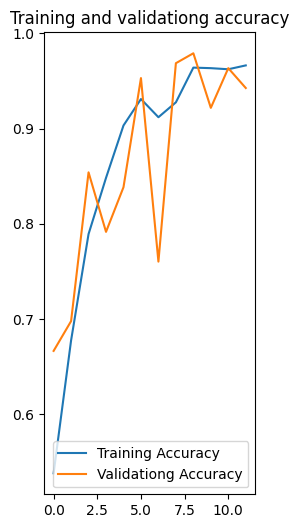

In [30]:
plt.figure(figsize=(6,6))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validationg Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validationg accuracy')

First image to predict : 
Actual label Potato___Late_blight
1/1 [==============================] - 0s 346ms/step
[7.4130885e-06 9.9999154e-01 1.0741844e-06]
1


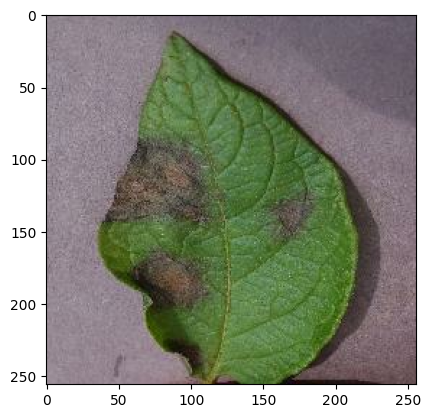

In [31]:
import numpy as np

for image_batch, label_batch in test_ds.take(1):
    first_image= image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('First image to predict : ')
    plt.imshow(first_image)
    print('Actual label', class_names[first_label])
    
    batch_prediction  = model.predict(image_batch)
    print((batch_prediction[0]))
    print(np.argmax(batch_prediction[0]))

In [32]:
def predict(model, img):
    img_array =  tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


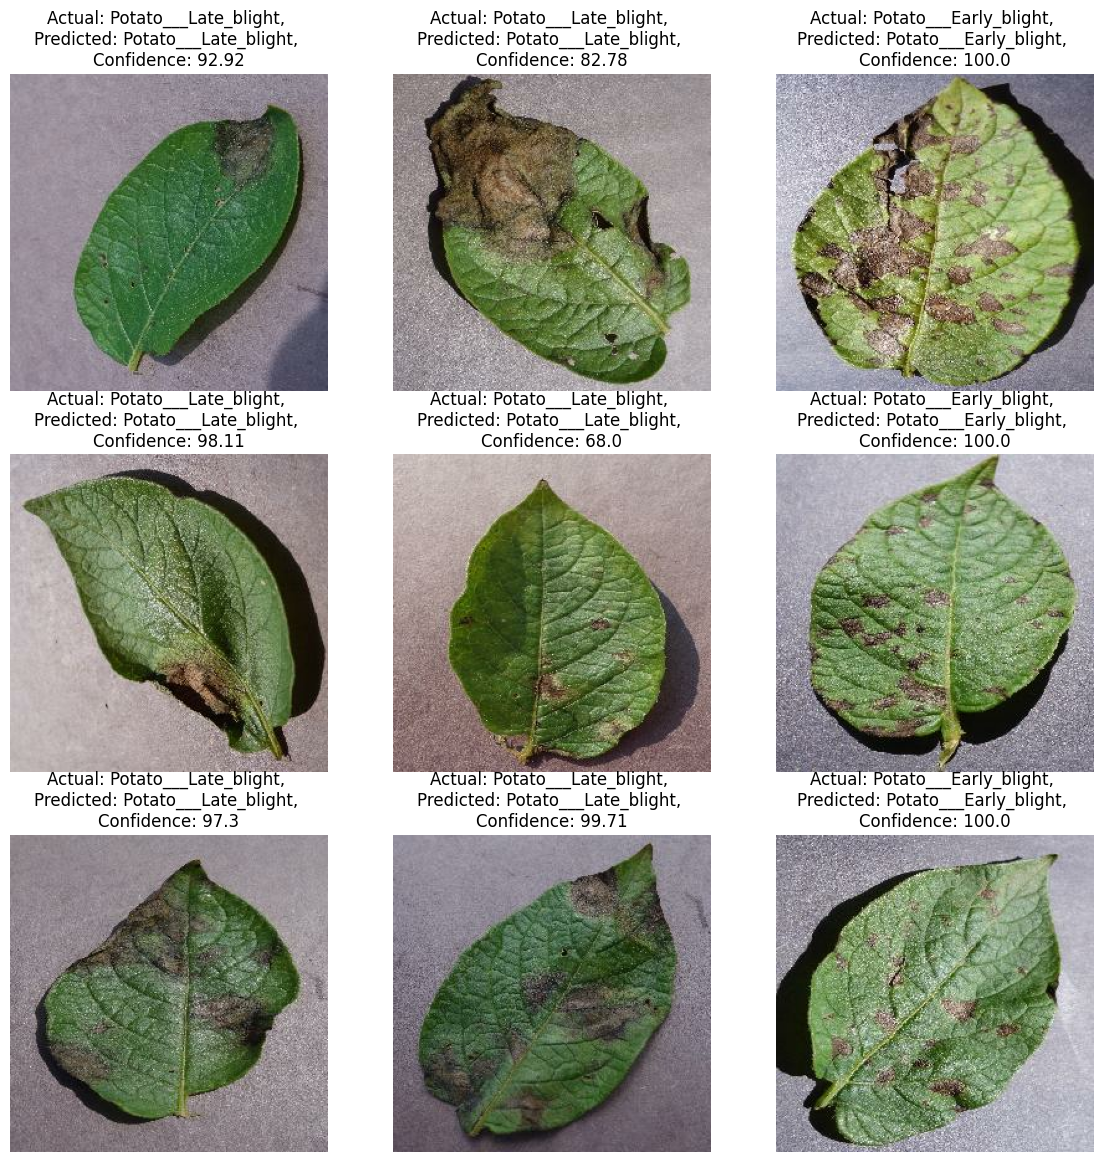

In [33]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}')
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')